# Computational Graphs - Function Optimization
*Christoph Heindl 2017, https://github.com/cheind/py-cgraph/*

This is part three in series about computational graphs and their applications. In the previous parts the fundamental concepts were covered. We also introduced a library called CGraph to perform symbolic computation in Python.

This part is about putting CGraph into practice. It deals with function optimization in which derivatives are required to determine stationary points.

## Function optimization

Now with all the puzzle-pieces in place and a working symbolic computation engine (at least for computing derivatives) at hand, we will apply it to function optimization. In particular, we will be dealing with least squares problems in which the residuals are linear, though nothing prevents you from applying it to other non-linear problems.

Our secenario is as follows: Given a set of noisy two-dimensional points fit a straight line. Everyone whose done ordinary linear least square regression knows that there is a 'closed-form' solution to the problem that involves nothing but a couple of matrix multiplications and an inversion. However, here we shall use the best-fit solution only as reference and concentrate more on gradient descent methods that are also the driving horses for training neural networks.

For the time being, we'll be using [cgraph.py](../cgraph.py) directly, as it contains operations that we haven't implemented yet in the previois part. The complete example can be found exercised here is also available as a separate [example_optimize.py](../example_optimize.py) file.

In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('..')
import cgraph as cg
import numpy as np
np.seterr(all='ignore');

import time

import sdf
import cgraph as cg
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection

def explicit_euler(x, v, dx, dv, t, dt):
    xnew = np.empty(x.shape)
    vnew = np.empty(v.shape)
    
    xnew = x + dx * dt
    vnew = v + dv * dt

    return xnew, vnew

def timeit(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('Took {}'.format(time2-time1))
        return ret
    return wrap

class ParticleSimulator:

    def __init__(self, f, particle_creator, timestep=1/30):
        self.p = None        
        self.dt = timestep
        
        self.sdf = f
        self.particle_creator = particle_creator
        self.force_generators = []
        self.integrator = explicit_euler       
        
    def reset(self):
        self.p = self.particle_creator()
        self.p['f'] = np.zeros((self.p['n'], 2))

        self.t = 0
        self.current_wall_time = time.time()
        self.tacc = 0.      

    def forces(self):
        facc = self.p['f']
        
        facc.fill(0.)
        for fg in self.force_generators:
            k = fg(self.p, self.t)
            facc += k

        return facc

    def dynamics(self):
        dx = np.empty((self.p['n'], 2))
        dv = np.empty((self.p['n'], 2))

        dx[:] = self.p['v']
        dv[:] = self.forces() / self.p['m'][:, np.newaxis]

        return dx, dv

    #@timeit
    def update(self):
        new_wall_time = time.time()
        frame_time = new_wall_time - self.current_wall_time
        self.current_wall_time = new_wall_time
        self.tacc += frame_time

        while self.tacc >= self.dt:
            self.advance()
            self.tacc -= self.dt
            self.t += self.dt
    
    
    def advance(self):
        xcur = self.p['x']
        vcur = self.p['v']

        dx, dv = self.dynamics()
        xnew, vnew = self.integrator(xcur, vcur, dx, dv, self.t, self.dt)
        
        d, g = self.sdf(xnew[:, 0], xnew[:, 1], compute_gradient=True)
        d -= self.p['r'] # Correct for radius of particles

        cids = np.where(d <= 0)[0]
        if len(cids) > 0:
            # Collision response for items in collision     
            g = g[cids]
            n = g / np.linalg.norm(g, axis=1)[:, np.newaxis]

            x = xnew[cids]
            v = vnew[cids]
            cr = self.p['cr'][cids, np.newaxis]
            cf = self.p['cf'][cids, np.newaxis]

            vn = np.sum(v * n, axis=1)[:, np.newaxis] * n
            vt = v - vn

            xnew[cids] = x - (1 + cr) * d[cids, np.newaxis] * n
            vnew[cids] = -cr * vn + (1 - cf) * vt
        
        self.p['x'][:] = xnew
        self.p['v'][:] = vnew

def plot_background(fig, ax, f, bounds=[(-2,2), (-2,2)], show_quiver=True, show_isolines='all'):
    
    ax.set_xlim(bounds[0])
    ax.set_ylim(bounds[1])
    ax.set_aspect('equal')
    ax.tick_params(
        axis='both',
        which='both',
        bottom='off',
        top='off',
        left='off',
        right='off',
        labelbottom='off',
        labeltop='off',
        labelleft='off',
        labelright='off',
    )

    if show_quiver or show_isolines:
        x, y, d, g = sdf.grid_eval(f, bounds=bounds)
        
        if show_isolines == 'all':
            cont = ax.contour(x, y, d)
        elif show_isolines == 'zero':
            cont = ax.contour(x, y, d, levels=[0])       

        if show_quiver:
            dx = g[:,:,0]
            dy = g[:,:,1]

            skip = (slice(None, None, 5), slice(None, None, 5))
            ax.quiver(x[skip], y[skip], dx[skip], dy[skip], d[skip])


def create_animation(fig, ax, ps, bounds=[(-2,2), (-2,2)], frames=500, timestep=1/30, repeat=True):
    patches = []

    def init_anim():
        ps.reset()
        return []

    def update_anim(i):
        if i == 0:
            actors = [plt.Circle((0,0), radius=ps.p['r'][i]) for i in range(ps.p['n'])]        
            patch = ax.add_artist(PatchCollection(actors, offset_position='data', alpha=0.6, zorder=10))
            patch.set_array(np.random.rand(len(actors)))
            patches.append(patch)
            
        ps.update()        
        patches[0].set_offsets(ps.p['x'])
        return patches

    anim = animation.FuncAnimation(
        fig, 
        update_anim,  
        init_func=init_anim,
        interval=timestep * 1000,
        frames=frames,
        repeat=repeat,
        blit=True)

    return anim

f = sdf.Line(normal=[0, 1], d=-1.8) | sdf.Line(normal=[1, 1], d=-1.8) | sdf.Line(normal=[-1, 1], d=-1.8)
f = f | (sdf.Circle(center=[0, -0.8], radius=0.5) & sdf.Line(normal=[0.1, 1], d=-0.5))

def gravity(p, t):
    return p['m'][:, np.newaxis] * np.array([0, -1]) 

#f = f | sdf.Line(normal=[0, -1], d=-1.8)
g = sdf.GridSDF(f, samples=[100j, 100j])
def grad(p, t, f=g):
    """Force along gradients for fun"""
    d, g = f(p['x'][:, 0], p['x'][:, 1], compute_gradient=True)
    return g * p['m'][:, np.newaxis]

def create_particles(n=100):
    p = {}
    p['n'] = n
    p['x'] = np.random.multivariate_normal([0, 1], [[0.05, 0],[0, 0.05]], n)
    p['v'] = np.random.multivariate_normal([0, 0], [[0.1, 0],[0, 0.1]], n)
    p['m'] = np.random.uniform(1, 10, size=n)
    p['r'] = p['m'] * 0.01
    p['cr'] = np.full(n, 0.6)
    p['cf'] = np.full(n, 0.3)
    return p

First, we define a function that generates a set of noisy points along an ideal line parametrized by $y = w_0*x+w_1$

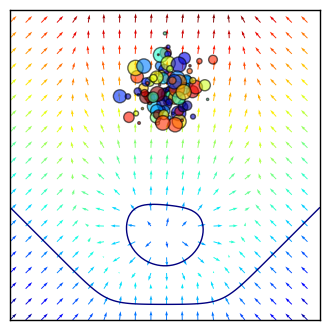

In [7]:
ps = ParticleSimulator(g, create_particles, timestep=1/60)
ps.force_generators += [gravity]

plt.clf()
fig, ax = plt.subplots()
plot_background(fig, ax, g, show_quiver=True, show_isolines='zero')

from matplotlib import rc
rc('animation', html='html5')

anim = create_animation(fig, ax, ps, frames=10)
from IPython.display import HTML
HTML(anim.to_html5_video())
